1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [32]:
import pandas as pd

df =pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv')
df.head()

,Unnamed: 0,default,student,balance,income
0,1,No,No,729.526495,44361.625074
1,2,No,Yes,817.180407,12106.134700
2,3,No,No,1073.549164,31767.138947
3,4,No,No,529.250605,35704.493935
4,5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [33]:
#set 'No' to 0.0, 'Yes' to 1.0

df_default = pd.get_dummies(df['default'])
df_default.drop('No', inplace=True, axis=1)
df_default = df_default.rename(columns={'Yes': 'default'})

df_student = pd.get_dummies(df['student'])
df_student.drop('No', inplace=True, axis=1)
df_student = df_student.rename(columns={'Yes': 'student'})

df_final = pd.concat([df_default,df_student,df[['balance','income']]],axis=1)
df_final.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

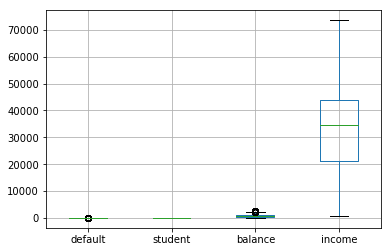

In [34]:

import pylab as plt
%matplotlib inline

fig1 = df_final.boxplot()
plt.show(fig1)

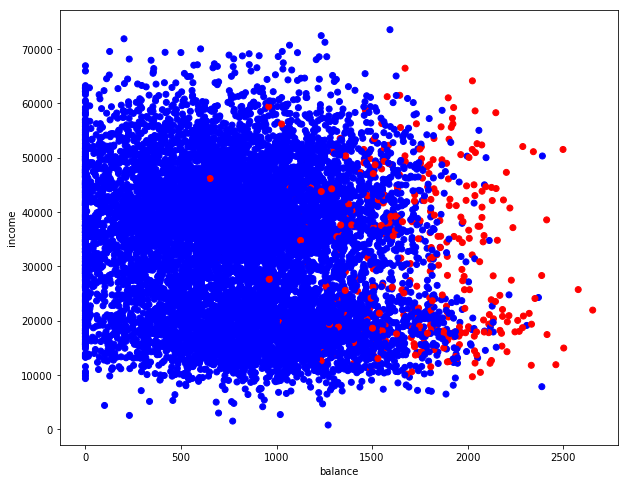

In [35]:
fig, ax = plt.subplots(figsize=(10,8))
colors = {'Yes':'red', 'No':'blue'}
plt.xlabel('balance')
plt.ylabel('income')
ax.scatter(df_final['balance'], df_final['income'], c=df['default'].apply(lambda x: colors[x]))
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

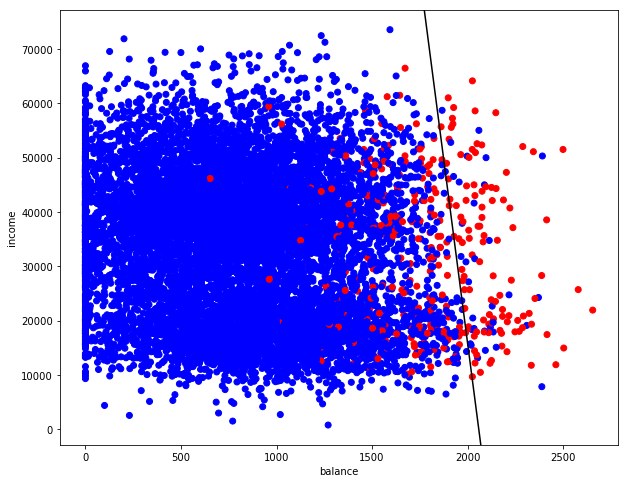

In [36]:
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

#train the model using Logistic Regression
X = df_final[['balance','income']]
y = df_final['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
regr = LogisticRegression(penalty='l1')
regr.fit(X_train, y_train)

#Plot the data points
fig, ax = plt.subplots(figsize=(10,8))
colors = {'Yes':'r', 'No':'b'}
plt.xlabel('balance')
plt.ylabel('income')
ax.scatter(df_final['balance'], df_final['income'], c=df['default'].apply(lambda x: colors[x]))

#Plot the decision boundary
b = regr.intercept_
coef = regr.coef_[0]

axes = plt.gca()
x_min, x_max = axes.get_xlim()
y_min, y_max = axes.get_ylim()

x = np.arange(x_min, x_max, 1)
y = (b + coef[0] * x) / -coef[1]

plt.plot(x, y,c='black')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()

Area under the ROC curve : 0.957734


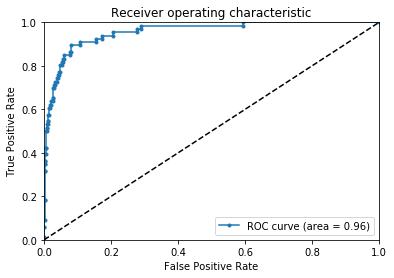

In [37]:
from sklearn.metrics import roc_curve, auc

#Compute the AUC ROC
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

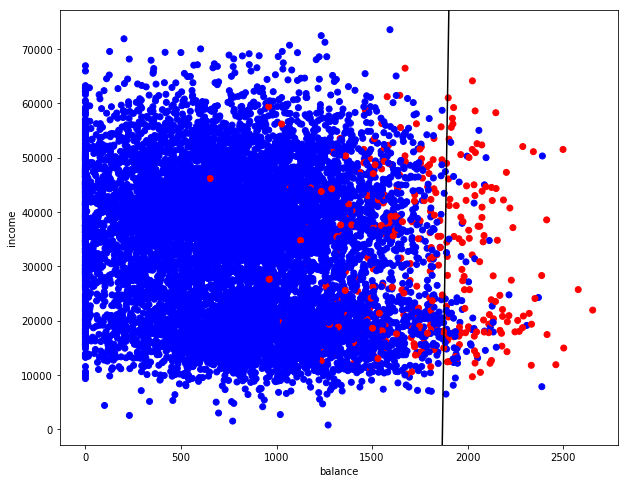

In [38]:


X = df_final[['balance','income','student']]
y = df_final['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
regr = LogisticRegression(penalty='l1')
regr.fit(X_train, y_train)

#Plot the data points
fig, ax = plt.subplots(figsize=(10,8))
colors = {'Yes':'r', 'No':'b'}
plt.xlabel('balance')
plt.ylabel('income')
ax.scatter(df_final['balance'], df_final['income'], c=df['default'].apply(lambda x: colors[x]))

#Plot the decision boundary
b = regr.intercept_
coef = regr.coef_[0]

axes = plt.gca()
x_min, x_max = axes.get_xlim()
y_min, y_max = axes.get_ylim()

x = np.arange(x_min, x_max, 1)
y = (b + coef[0] * x) / -coef[1]

plt.plot(x, y,c='black')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()


In [39]:

X = df_final[['balance','income','student']]
y = df_final['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Create linear regression object
alphas = np.logspace(-3,0,20)

scores = []

for alpha in alphas:
    regr = LogisticRegression(C=alpha,penalty='l1')
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    scores.append(regr.score(X_test,y_test))


In [40]:
alpha_best = alphas[np.argmax(scores)]
print(alpha_best)

0.483293023857


Area under the ROC curve : 0.973800


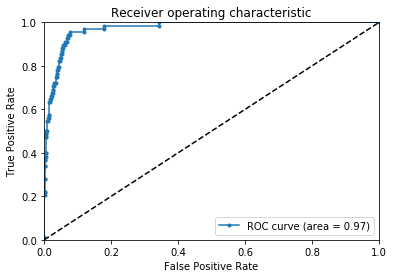

In [41]:
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=alpha_best,penalty='l1')
generate_ROCplot(fpr,tpr,'LR',roc_auc)

[[  3.76538061e-04  -1.24731953e-04  -2.53483338e-06]]


/Users/bindy/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


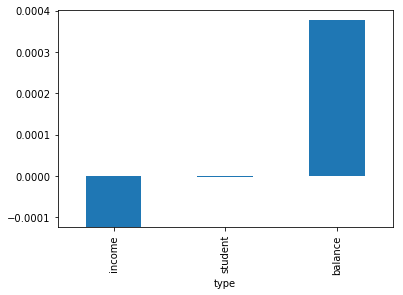

In [42]:
#Plot the ranking of the coefficients
clf =  LogisticRegression(C=alpha_best,penalty='l2').fit(X_train,y_train)
print(clf.coef_)
df_Coeff = pd.DataFrame({'type':['balance','income','student'], 'coef':clf.coef_[0]})
df_Coeff2 = df_Coeff.groupby('type')['coef'].mean()
df_Coeff2.sort('coef')
df_Coeff2.plot(x='type',y='coef',kind='bar')
plt.show()

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

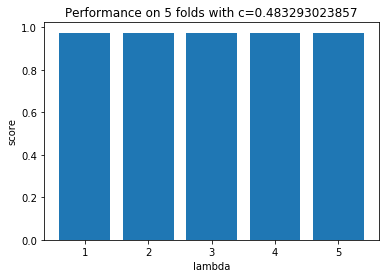

In [43]:
from sklearn.model_selection import cross_val_score
regr = LogisticRegression(C=alpha_best,penalty = 'l2')
scores = cross_val_score(regr, X, y, cv=5)
plt.xlabel('lambda')
plt.ylabel('score')
plt.title('Performance on 5 folds with c=' + str(alpha_best))
plt.bar(range(1,6),scores)
plt.show()

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

Automatically created module for IPython interactive environment


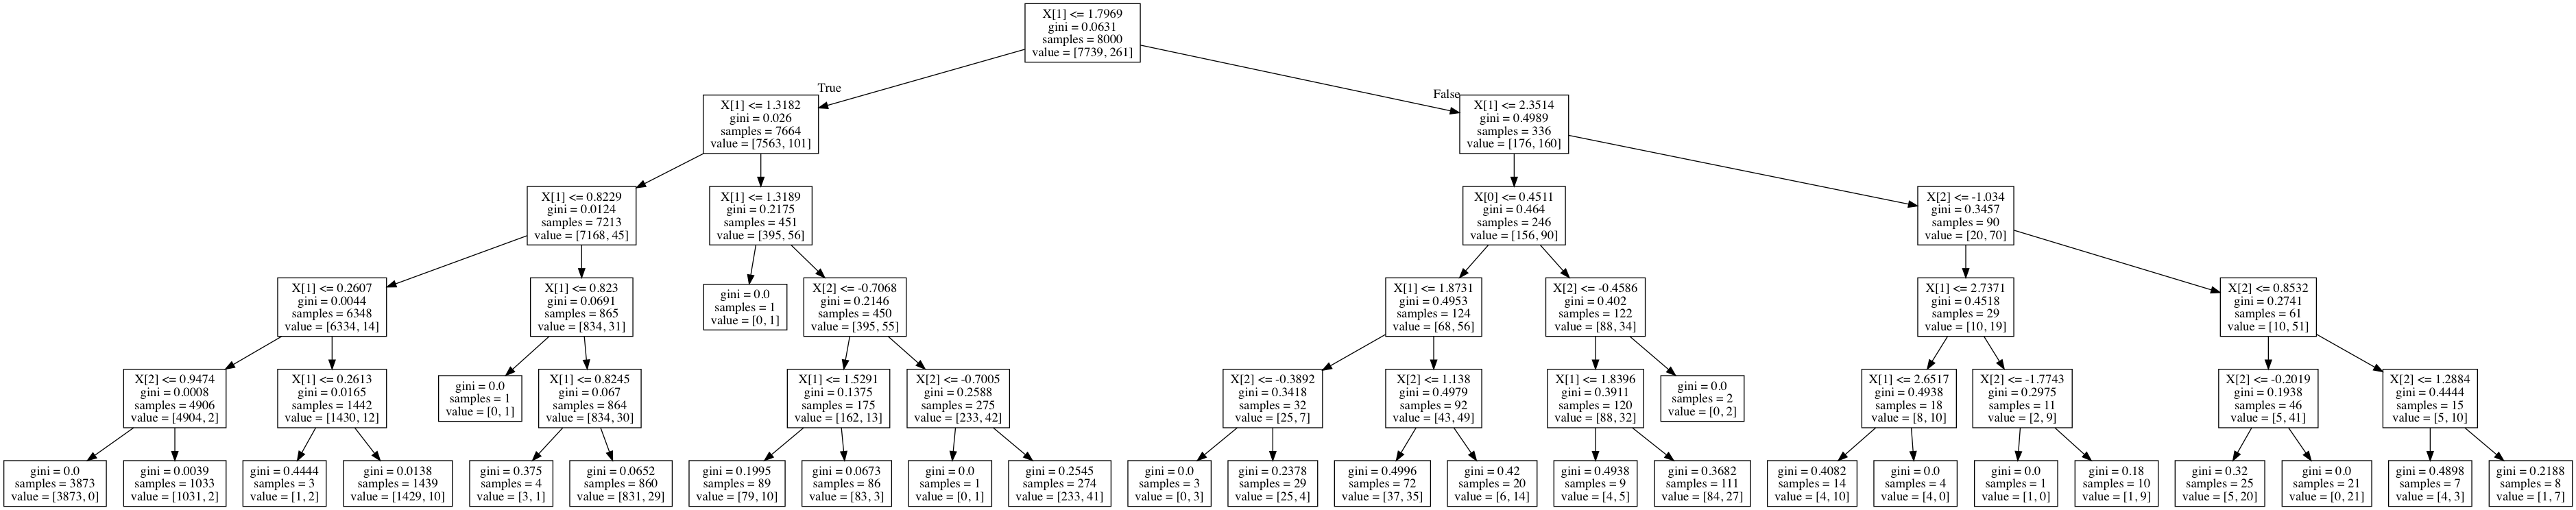

In [44]:
# Import the necessary modules and libraries
import os
import subprocess
import pandas as pd
import numpy as np
from PIL import Image, ImageFilter
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus
from IPython.display import Image
X = df_final[['balance','income','student']]
y = df_final['default']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")
        
        
X = df_final[['student','balance','income']]
y = df_final['default']

scaler = StandardScaler()
X = X.as_matrix().astype(np.float)
X = scaler.fit_transform(X)
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2)



print(__doc__)


%matplotlib inline


# Fit regression model
regr = DecisionTreeClassifier(max_depth=5)
regr.fit(X_train, y_train)


# Predict

y = regr.predict(X_test)


dt=DecisionTreeClassifier(max_depth=5)
visualize_tree(regr, feature_names=['x'])


dot_data=export_graphviz(regr, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

8) Find the optimal decision tree depth and compute the AUC ROC. 

In [45]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

scores = []
depths = []

for depth in range(1,101):
    
    dt=DecisionTreeClassifier(max_depth=depth)
    # Train the model using the training sets
    dt.fit(X_train, y_train)
    scores.append(dt.score(X_test,y_test))
    depths.append(depth)
    
depth_best = depths[np.argmax(scores)]
print(depth_best)

2


Area under the ROC curve : 0.907597


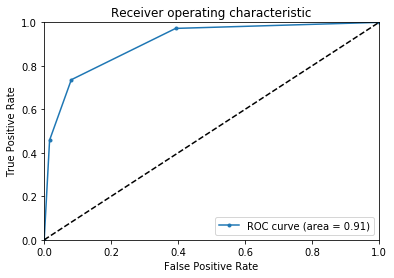

In [46]:
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth=depth_best,criterion='entropy')
generate_ROCplot(fpr,tpr,'LR',roc_auc)